In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
from clustering_and_prim_tools import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [6]:
data = pd.read_excel("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\energy_kth_output_data\\SAMBA scenario results all runs_revised CO2 limit.xlsx","Capital inv variable and fixed")

In [7]:
data.sample(5)

,DMD,FUEL,CC RE,DR,CO2,CC,Parameter (million USD),2013,2014,2015,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
665,3,1,1,1,3,2,CapitalInvestment,133.712600,21097.136732,30081.302202,...,73309.546263,71889.838001,76935.990846,72546.253599,84693.454404,80806.120894,78167.333646,79887.721700,86967.698160,83853.345277
220,1,3,2,1,1,2,AnnualVariableOperatingCost,23736.982014,25166.563181,14690.847642,...,18859.983038,18929.160824,19152.025369,19353.997397,19811.974155,20132.246606,20328.606082,20416.887226,20621.992764,20710.511762
658,3,1,1,1,2,2,AnnualVariableOperatingCost,23736.982014,24679.344251,14648.484490,...,24750.123698,25260.208760,26356.919249,26749.500050,27585.450331,27957.557829,28095.413310,28281.117792,28936.350563,29591.545402
473,2,1,3,3,1,2,CapitalInvestment,24.570676,29531.643049,44201.333342,...,105869.733394,119659.923679,130680.844116,126571.897198,143248.008905,136845.243096,144891.143275,156263.695239,167756.895645,219614.826594
952,3,3,3,2,3,2,AnnualVariableOperatingCost,23737.879160,24681.102106,14650.085755,...,47332.652216,49660.095141,52637.150572,54739.425203,57185.160360,59638.684984,62013.306125,64370.544321,66938.703708,65924.303899


In [8]:
new_data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).sum(axis=1).unstack("Parameter (million USD)").reset_index()

### separate uncertain factors from results

In [9]:
inputs = new_data[['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC']]

### results (costs)

In [10]:
new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].describe()

Parameter (million USD),CapitalInvestment,AnnualFixedOperatingCost,AnnualVariableOperatingCost
count,3.240000e+02,324.000000,3.240000e+02
mean,2.109196e+06,401662.812550,9.663333e+05
std,6.446533e+05,40104.127269,2.676347e+05
min,1.234056e+06,325863.115023,6.441355e+05
25%,1.600893e+06,376618.897218,7.758696e+05
50%,1.960887e+06,397458.345427,8.782428e+05
75%,2.402974e+06,422699.560905,1.071958e+06
max,4.321485e+06,506822.532554,1.881458e+06


In [11]:
new_data['tot_cost'] = new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [12]:
new_data['tot_cost'].describe()

count    3.240000e+02
mean     3.477192e+06
std      7.180726e+05
min      2.450426e+06
25%      2.922814e+06
50%      3.353408e+06
75%      3.896563e+06
max      5.858908e+06
Name: tot_cost, dtype: float64

In [13]:
new_data['annual_cost'] = new_data[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

### clustering and scenario discovery functions 

In [14]:
oois = ['annual_cost','CapitalInvestment']

data = np.array([[new_data[oois[0]][0],new_data[oois[1]][0]]])
for i in range(1,len(new_data.index)):
    data = np.concatenate((data,np.array([[new_data[oois[0]][i],new_data[oois[1]][i]]])))

data_norm = normalize(data)

In [15]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

### looking for the clusters that gives the best PRIM results (the number of clusters is chosen by the algorithm) 

In [16]:
while n_clusters>2:

    condition = True

    for i in get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)[0]:
        if i.coverage+i.density < seuil:
            condition = False
        else:
            condition = condition&True
    if condition == True:
        break
    else:
        n_clusters = n_clusters - 1
        continue


#Plot of clusters


dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)
boxes = dummy[0]
df = dummy[1]

### the algorithm has found 3 clusters 

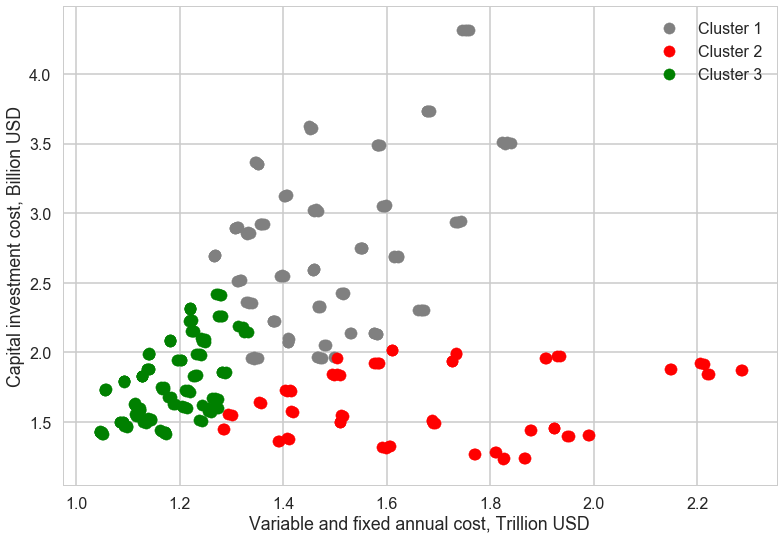

In [27]:
mycolors = ["grey","red","green","blue"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(1e-6*subdf.annual_cost,1e-6*subdf.CapitalInvestment,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("Variable and fixed annual cost, Trillion USD")
plt.ylabel("Capital investment cost, Billion USD")
plt.savefig("clusters.png")

### below are PRIM results for each cluster

#### cluster 1  

In [24]:
boxes[0].limits

,min,max,qp values
CO2,1.0,2.0,5.475635e-07
DMD,2.0,3.0,2.269133e-05
DR,2.0,3.0,2.024737e-04


#### cluster 2 

In [25]:
boxes[1].limits

,min,max,qp values
CO2,3.0,3.0,6.286701e-15
DR,2.0,3.0,1.106845e-04


#### cluster 3 (red: high capital costs) is explained by a strong CO2 constraint, high demand and high discount rate 

In [26]:
boxes[2].limits

,min,max,qp values
DR,1.0,2.0,1.454294e-12
DMD,1.0,2.0,6.873636e-08


In [30]:
inputs.describe()

Parameter (million USD),DMD,FUEL,CC RE,DR,CO2,CC
count,324.00000,324.000000,324.00000,324.00000,324.00000,324.000000
mean,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000
std,0.81776,1.001547,0.81776,0.81776,0.81776,0.500773
min,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000
25%,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000
50%,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000
75%,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000
max,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000
